In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material')
import os

import geometry as gm
#import conversion as cnv
from func_statistics import compute_pdf_nbin, slopes_r_p, slopes_r_p_onlysub, slopes_r_p_mix, slope_time, slope_maps
import regression
#from coare_functions import *
import meteo
import lcl
import metpy.calc as mpcalc
from metpy.units import units


import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [4]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy'):
    sea_mask_modified = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy')
    sea_mask_modified_nan = np.ones_like(sea_mask_modified)
    sea_mask_modified_nan[sea_mask_modified==0] = np.nan
    
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy')    
    
tourbillons_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/tourbillons_mask.npy')
open_ocean_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/open_ocean_mask.npy')

In [5]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)


perc_step = 5
nbins = int(100/perc_step) # Number of bins.
popmean = 0

In [6]:
# retrieve SST, temperature, "buoyancy" and PBLH

In [7]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

In [8]:
# lat and lon
lon_M = ds_hourly['nav_lon'].values
lat_M = ds_hourly['nav_lat'].values

In [9]:
sst_day = ds_hourly['SST'].groupby('time_counter.day').mean()            
sst_day = sst_day.where(sea_mask_modified, drop=False).values; 

In [10]:
T2 = ds_hourly['T2'].groupby('time_counter.day').mean()
T2 = T2.where(sea_mask_modified, drop=False).values

In [11]:
s = 100

dT2 = np.zeros(T2.shape)
T2_smooth = np.zeros(T2.shape)

for t in range(0,T2.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    T2_smooth[t] = gm.nan_gaussian_filter(T2[t],s)                             
    dT2[t] = T2[t] - T2_smooth[t]
    

0
10
20


In [10]:
my_save_data('/venus/tesi_ale/data_EU/T/daily/FEB/dT2_day_feb.npy', [dT2])

In [8]:
buoya = sst_day - T2

In [12]:
PBLH_day = ds_hourly['PBLH'].groupby('time_counter.day').mean()            
PBLH_day = PBLH_day.where(sea_mask_modified, drop=False).values; 

In [48]:
buoya_flat = buoya[~np.isnan(buoya)].flatten()
#buoya_flat = np.sort(buoya_flat)
perc_99 = np.percentile(buoya_flat, 99); print(f'perc 99 = {perc_99}')
perc_95 = np.percentile(buoya_flat, 95); print(f'perc 95 = {perc_95}')
perc_75 = np.percentile(buoya_flat, 75); print(f'perc 75 = {perc_75}')
perc_3_5 = np.percentile(buoya_flat, 3.5); print(f'perc 3.5 = {perc_3_5}')

perc 99 = 1.313720703125
perc 95 = 1.12005615234375
perc 75 = 0.870086669921875
perc 3.5 = -0.00152587890625


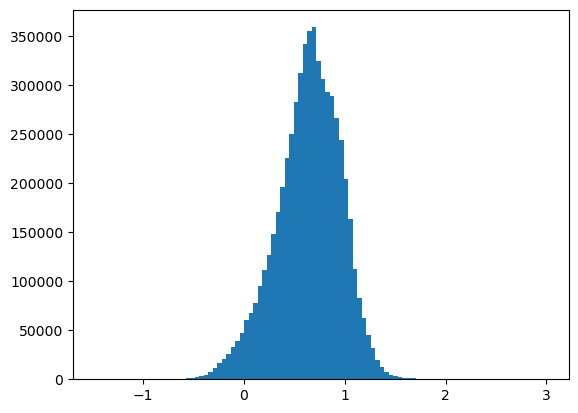

In [46]:
res= plt.hist(buoya_flat[buoya_flat<3], bins=100)
freq = res[0]/(len(buoya_flat[buoya_flat<3]))
bin_ave = 0.5*(res[1][0:-1]+res[1][1:])

In [10]:
### LOAD ANOMALIES DATA FROM SAVED FILES

ds_sst = xr.open_dataset('/venus/tesi_ale/data_EU/SST/hourly/FEB/dSST_feb.nc')
dsst_day = ds_sst['dsst_day']*sea_mask_modified_nan
    
# with open('/venus/tesi_ale/data_EU/PBLH/daily/FEB/dPBLH_day_feb.npy', 'rb') as f:
#     dPBLH_day = np.load(f)

In [11]:
#######   SEE BEHAVIOUR OF SURFACE HEAT FLUXES

In [12]:
LH = ds_hourly['LH'].groupby('time_counter.day').mean()            
LH = LH.where(sea_mask_modified, drop=False).values; 

# HFX = ds_hourly['HFX'].groupby('time_counter.day').mean()            
# HFX = HFX.where(sea_mask_modified, drop=False).values; 

In [13]:
s = 100

dLH, LH_smooth = np.zeros(LH.shape), np.zeros(LH.shape)

for t in range(0,LH.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    LH_smooth[t] = gm.nan_gaussian_filter(LH[t],s)                             
    dLH[t] = LH[t] - LH_smooth[t]
    
#     HFX_ave = gm.nan_gaussian_filter(HFX[t],s)                             
#     dHFX[t] = HFX[t] - HFX_ave

0
10
20


In [24]:
my_save_data('/venus/tesi_ale/data_EU/LH/daily/FEB/dLH_day_feb.npy', [dLH])
my_save_data('/venus/tesi_ale/data_EU/HFX/daily/FEB/dHFX_day_feb.npy', [dHFX])

file already exists - DELETING IT and creating it anew
file already exists - DELETING IT and creating it anew


In [17]:
dLH_xr = xr.DataArray(dLH, name='dLH', dims=['day', 'lat', 'lon'])
dLH_xr.attrs['long name'] = '200km anomalies of daily LHF'
dLH_xr.attrs['units'] = 'W/m2'

dHFX_xr = xr.DataArray(dHFX, name='dHFX', dims=['day', 'lat', 'lon'])
dHFX_xr.attrs['long name'] = '200km anomalies of daily HFX'
dHFX_xr.attrs['units'] = 'W/m2'


ds_heats = xr.Dataset()

ds_heats = ds_heats.assign(dLH=dLH_xr, dHFX=dHFX_xr)
ds_heats.to_netcdf('/venus/tesi_ale/data_EU/LH/daily/FEB/heats_anomalies.nc')

In [19]:
# DISTRIBUTIONS

In [13]:
ds_ht = xr.open_dataset('/venus/tesi_ale/data_EU/LH/daily/FEB/heats_anomalies.nc')
dLH = ds_ht['dLH'].values*sea_mask_modified_nan
dHFX = ds_ht['dHFX'].values*sea_mask_modified_nan

In [17]:
### LARGE SCALE HEATS
LH_ls = LH-dLH
HFX_ls = HFX-dHFX

In [14]:
#########    LH     #########
mask = sea_mask_modified_nan  #open_ocean_mask   # open_ocean_mask  #tourbillons_mask

In [77]:
# dSST vs dLH
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

pdist_x, pdist_dLH, pstd_dLH, pstderr_dLH, pnpoints_dLH, ppvalue_dLH =   distrib_2d(dsst_day.values*mask, dLH*mask, perc_step, nbins, popmean, perc_fixbin='perc')

In [78]:
# SST vs LH
pdist_sst, pdist_LH, pstd_LH, pstderr_LH, pnpoints_LH, ppvalue_LH =   distrib_2d(sst_day*mask, LH*mask, perc_step, nbins, popmean, perc_fixbin='perc')

NameError: name 'xx' is not defined

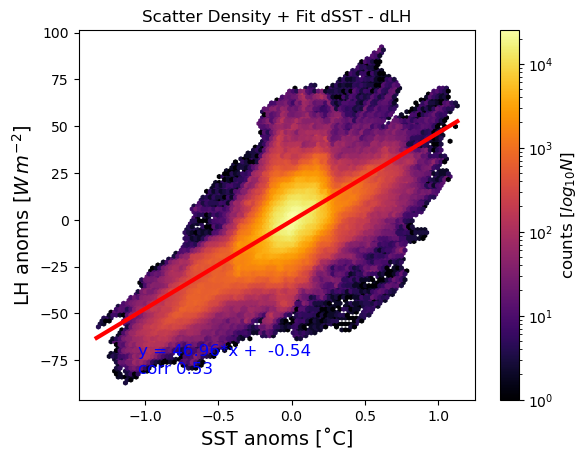

In [16]:
##### FITTING #####

# # corr length
# L = 80
# nskip = int(L/2)
# nt = int(2)
# nbin = 50
dsst = True

if not dsst:
    x =  (sst_day-273.15).copy()*mask    
    y =  LH.copy()*mask
    
#     xx = pdist_sst-273.15
#     yy = pdist_LH
    
    fit, corcoe, p_value, p_value_cannelli, sigmas_sst_lh = slopes_r_p_mix(x, y, nt, nskip)
    title=' Scatter Density + Fit SST - LH'
    xlabel='SST [˚C]'
    ylabel='LH [$W\,m^{-2}$]'
    
else:
    x = dsst_day.values.copy()*mask 
    y = dLH.copy()*mask
    
#     xx = pdist_x
#     yy = pdist_dLH
    
    fit, corcoe, p_value, p_value_cannelli, sigmas_dsst_dlh = slopes_r_p_mix(x, y, nt, nskip)
    title='Scatter Density + Fit dSST - dLH'
    xlabel='SST anoms [˚C]'
    ylabel='LH anoms [$W\,m^{-2}$]'
    miny = -150 ; maxy = 100
    minx = -2 ; maxx = 1
    
pos = [0.15, 0.12]
fig = density_hexbin(x,y,plot_fit=True,fit=fit,corcoe=corcoe,grdsz=100,title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno', pos=pos)
# plt.plot(xx, yy, '*b')

# plt.xlim([24.5,28.7])
# plt.ylim([20,350]) 


if dsst:
    plt.vlines(0, ymin=miny, ymax=maxy, color='red', linewidth=1)
    plt.hlines(0, xmin=minx, xmax=maxx, color='red', linewidth=1)
    
if p_value_cannelli < 0.05:
    plt.annotate('slope p < 5%', xy=(pos[0], pos[1]-0.1), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    plt.annotate('slope p > 5%', xy=(pos[0], pos[1]-0.1), \
                         xycoords='axes fraction', fontsize=12, color='b')

    

path_img = '/venus/tesi_ale/img_EU/LH/daily/FEB/' 
filename = path_img + 'scatterFIT_dsst_dLH_fullDom.png' if dsst else path_img + 'scatterFIT_sst_LH_fullDom.png'
# plt.savefig(filename)
print(filename)
del filename

In [ ]:
#########    HFX     #########

In [17]:
# dSST vs dHFX
pdist_x, pdist_dHFX, pstd_dHFX, pstderr_dHFX, pnpoints_dHFX, ppvalue_dHFX =   distrib_2d(dsst_day.values*mask, dHFX*mask, perc_step, nbins, popmean, perc_fixbin='perc')


In [18]:
# SST vs HFX
pdist_sst, pdist_HFX, pstd_HFX, pstderr_HFX, pnpoints_HFX, ppvalue_HFX =   distrib_2d(sst_day*mask, HFX*mask, perc_step, nbins, popmean, perc_fixbin='perc')


/venus/tesi_ale/img_EU/HFX/daily/FEB/scatterFIT_dsst_dHFX_fullDom.png


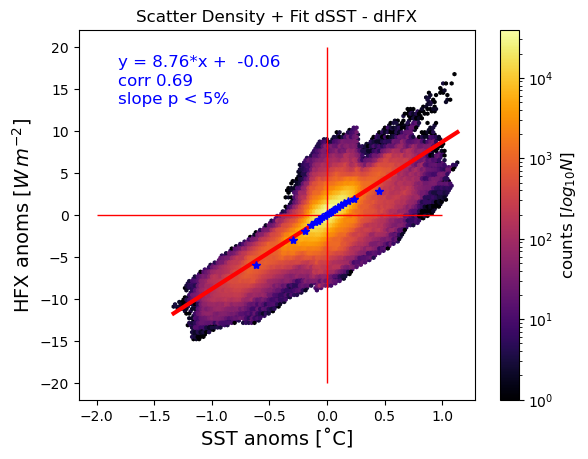

In [26]:
##### FITTING #####

# # corr length
# L = 80
# nskip = int(L/2)
# nt = int(2)
# nbin = 50
dsst = True

if not dsst:
    x = (sst_day-273.15).copy()*mask      
    y = HFX.copy()*mask
    
    xx, yy = pdist_sst-273.15, pdist_HFX
    
    fit_hfx, corcoe_hfx, p_value_hfx, p_value_cannelli_hfx, sigmas_hfx = slopes_r_p_mix(x, y, nt, nskip)
    title=' Scatter Density + Fit SST - HFX'
    xlabel='SST [˚C]'
    ylabel=r'HFX [$W\,m^{-2}$]'
else:
    x = dsst_day.values.copy()*mask
    y = dHFX.copy()*mask
    
    xx, yy = pdist_x, pdist_dHFX
    
    fit_hfx, corcoe_hfx, p_value_hfx, p_value_cannelli_hfx, sigmas_hfx = slopes_r_p_mix(x, y, nt, nskip)
    title='Scatter Density + Fit dSST - dHFX'
    xlabel='SST anoms [˚C]'
    ylabel=r'HFX anoms [$W\,m^{-2}$]'
    miny = -20 ; maxy = -miny
    minx = -2 ; maxx = 1

    
pos = [0.1, 0.9]
fig = density_hexbin(x,y,plot_fit=True,fit=fit_hfx,corcoe=corcoe_hfx,grdsz=100,title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno', pos=pos)
plt.plot(xx, yy, '*b')
    
'''fig1 = scatterplot_fit(x, y, fit, title, xlabel, ylabel, fig)
plt.annotate('corr coeff = '+str(round(corcoe,2)), xy=(0.1, 0.85), \
                     xycoords='axes fraction', fontsize=12, color='orange')'''
if dsst:
    plt.vlines(0, ymin=miny, ymax=maxy, color='red', linewidth=1)
    plt.hlines(0, xmin=minx, xmax=maxx, color='red', linewidth=1)
    
    
if p_value_cannelli_hfx < 0.05:
    plt.annotate('slope p < 5%', xy=(pos[0], pos[1]-0.1), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    plt.annotate('slope p > 5%', xy=(pos[0], pos[1]-0.1), \
                         xycoords='axes fraction', fontsize=12, color='b')


path_img = '/venus/tesi_ale/img_EU/HFX/daily/FEB/' 
filename = path_img + 'scatterFIT_dsst_dHFX_fullDom.png' if dsst else path_img + 'scatterFIT_sst_HFX_fullDom.png'
# plt.savefig(filename)
print(filename)
del filename

In [ ]:
#########    PBLH     #########

In [42]:
# dSST vs dPBLH
pdist_x, pdist_dPBLH, pstd_dPBLH, pstderr_dPBLH, pnpoints_dPBLH, ppvalue_dPBLH =   distrib_2d(dsst_day, dPBLH_day, perc_step, nbins, popmean, perc_fixbin='perc')
dist_x, dist_dPBLH, std_dPBLH, stderr_dPBLH, npoints_dPBLH, pvalue_dPBLH       =   distrib_2d(dsst_day, dPBLH_day, perc_step, nbins, popmean, perc_fixbin='fb')


In [45]:
# dSST vs PBLH
pdist_x, pdist_PBLH, pstd_PBLH, pstderr_PBLH, pnpoints_PBLH, ppvalue_PBLH =   distrib_2d(x, PBLH_day, perc_step, nbins, popmean, perc_fixbin='perc')
dist_x, dist_PBLH, std_PBLH, stderr_PBLH, npoints_PBLH, pvalue_PBLH       =   distrib_2d(x, PBLH_day, perc_step, nbins, popmean, perc_fixbin='fb')

In [ ]:
#### PLOTTING

one side probability for X2 > Xo2$ = 0.999999773912631 

/venus/tesi_ale/img_EU/LH/daily/FEB/scatterFIT_sst_LH_distribs.png


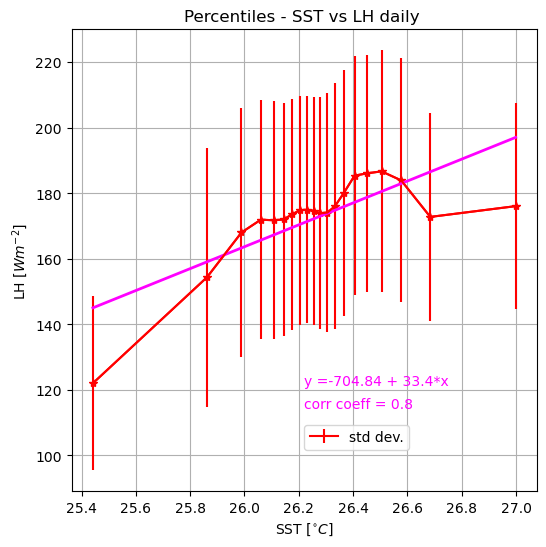

In [31]:
# dist_x vs dLH

full = True
from scipy.stats import chi2


fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))

title = 'SST vs LH daily' if full else 'dSST vs dLH daily'
xlabel = 'SST [$^{\circ}C$]' if full else 'dSST [$^{\circ}C$]'
ylabel = 'LH [$W\,m^{-2}$]' if full else 'dLH [$W\,m^{-2}$]'

x_p = pdist_sst-273.15 if full else pdist_x 
var_p = pdist_LH if full else pdist_dLH
std_p = pstd_LH if full else pstd_dLH

fit_p, corcoe_p, p_value_p, p_chisq, p_prob_chisq_grt, p_chisq_rid = slopes_r_p(x_p,var_p, std_p)

p1 = ax1.plot(x_p, var_p, '*-r') 
ax1.plot(x_p, fit_p.slope*x_p + fit_p.intercept, color='magenta', linewidth=2)
ax1.errorbar(x_p, var_p, yerr=std_p, xerr=None, color='r', label='std dev.')
ax1.set_xlabel(xlabel)
ax1.set_ylabel(ylabel)
ax1.set_title(f'Percentiles - {title} '); # ax1.grid()

ax1.annotate('y =' + str(round(fit_p.intercept, 2)) + ' + ' + str(round(fit_p.slope, 2)) + '*x', xy=(0.5, 0.23), \
                     xycoords='axes fraction', fontsize=10, color='magenta')
ax1.annotate('corr coeff = '+str(round(corcoe_p,2)), xy=(0.5, 0.18), \
                     xycoords='axes fraction', fontsize=10, color='magenta')
ax1.legend(loc='lower right', bbox_to_anchor=(0.74, 0.075))

ax1.grid()

# cumulative probability of chi2
print(f'one side probability for X2 > Xo2 = {p_prob_chisq_grt} \n')

path_img = '/venus/tesi_ale/img_EU/LH/daily/FEB/' 
filename = path_img + 'scatterFIT_sst_LH_distribs.png' if full else path_img + 'scatterFIT_dsst_dLH_distribs.png'
plt.savefig(filename)
print(filename)
del filename

In [44]:
np.sum(  (var_p-fit_p.slope*x_p-fit_p.intercept)**2 / pstd_dLH**2 )

0.8083325469398234

one side probability for X2 > Xo2 = 0.999999796482727 

/venus/tesi_ale/img_EU/HFX/daily/FEB/scatterFIT_sst_HFX_distribs.png


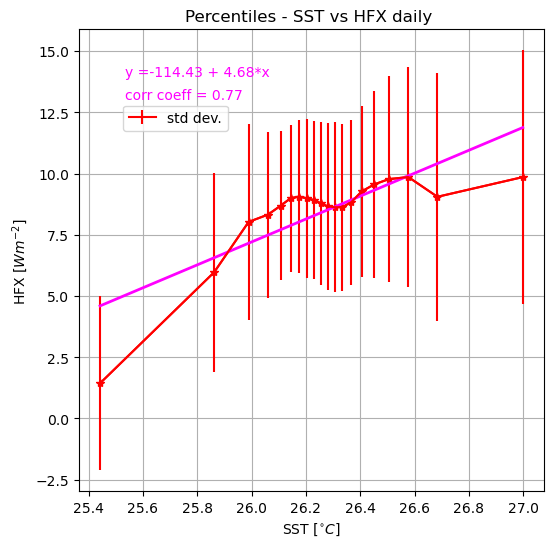

In [34]:
# dist_x vs dHFX

full = True



fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))

title = 'SST vs HFX daily' if full else 'dSST vs dHFX daily'
xlabel = 'SST [$^{\circ}C$]' if full else 'dSST [$^{\circ}C$]'
ylabel = 'HFX [$Wm^{-2}$]' if full else 'dHFX [$Wm^{-2}$]'

x_p = pdist_sst-273.15 if full else pdist_x 
var_p = pdist_HFX if full else pdist_dHFX
std_p = pstd_HFX if full else pstd_dHFX

fit_p_hfx, corcoe_p_hfx, p_value_p_hfx, p_chisq_hfx, p_prob_chisq_grt_hfx, p_chisq_rid_hfx = slopes_r_p(x_p,var_p, std_p)

p1 = ax1.plot(x_p, var_p, '*-r') 
ax1.plot(x_p, fit_p_hfx.slope*x_p + fit_p_hfx.intercept, color='magenta', linewidth=2)
ax1.errorbar(x_p, var_p, yerr=std_p, xerr=None, color='r', label='std dev.')
ax1.set_xlabel(xlabel)
ax1.set_ylabel(ylabel)
ax1.set_title(f'Percentiles - {title} '); # ax1.grid()

ax1.annotate('y =' + str(round(fit_p_hfx.intercept, 2)) + ' + ' + str(round(fit_p_hfx.slope, 2)) + '*x', xy=(0.1, 0.9), \
                     xycoords='axes fraction', fontsize=10, color='magenta')
ax1.annotate('corr coeff = '+str(round(corcoe_p_hfx,2)), xy=(0.1, 0.85), \
                     xycoords='axes fraction', fontsize=10, color='magenta')
ax1.legend(loc='upper left', bbox_to_anchor=(0.08, 0.85))


ax1.grid()

# cumulative probability of chi2
print(f'one side probability for X2 > Xo2 = {p_prob_chisq_grt_hfx} \n')




path_img = '/venus/tesi_ale/img_EU/HFX/daily/FEB/' 
filename = path_img + 'scatterFIT_sst_HFX_distribs.png' if full else path_img + 'scatterFIT_dsst_dHFX_distribs.png'
# plt.savefig(filename)
print(filename)
del filename

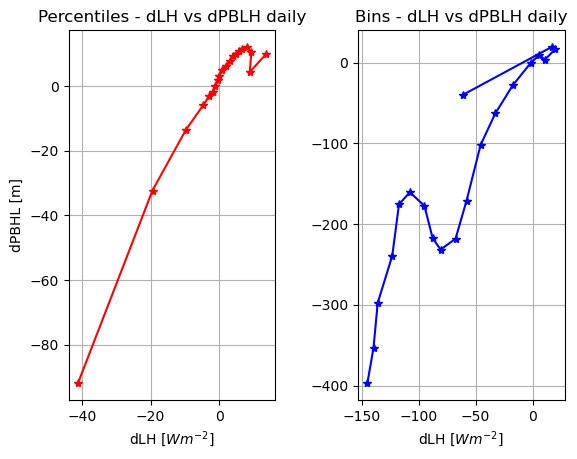

In [43]:
# dLH vs dPBLH

fig, (ax1, ax2) = plt.subplots(1, 2)

p1 = ax1.plot(pdist_dLH, pdist_dPBLH, '*-r')
ax1.set_xlabel('dLH [$Wm^{-2}$]')
ax1.set_ylabel('dPBHL [m]')
ax1.set_title('Percentiles - dLH vs dPBLH daily'); ax1.grid()

p2 = ax2.plot(dist_dLH, dist_dPBLH, '*-b')
ax2.set_xlabel('dLH [$Wm^{-2}$]')
ax2.set_title('Bins - dLH vs dPBLH daily'); ax2.grid()


plt.subplots_adjust(wspace=0.4, 
                    hspace=0.3)

In [27]:
#############    THERMODYNAMIC CONTRIBUTION TO dLH/dSST?

q2_day = ds_hourly['Q2'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
q2_day = q2_day.groupby('time_counter.day').mean()
q2_day = q2_day.where(sea_mask_modified, drop=False).values;

In [17]:
# retrieving pressure field

pres_base = xr.open_dataset(wrf_files[files_ls.index('PB.nc')])
pres_base = pres_base['PB']
# pres_base = pres_base[0,:,:]

pres = xr.open_dataset(wrf_files[files_ls.index('P.nc')]);  pres = pres['P']
pres = pres.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
pres = (pres+pres_base)/100.
#pres = pres.groupby('time_counter.day').mean()


# pres = pres.where(sea_mask_modified, drop=False)


del pres_base

In [18]:
# retrieving pressure at surface level
pres_sfc = pres[:,0,:,:]
pres_sfc = pres_sfc.where(sea_mask_modified, drop=False)
pres_sfc = pres_sfc.groupby('time_counter.day').mean()

del pres

In [ ]:
## load saturation vapour pressure
## computed in RH_calculation_only.ipynb

In [19]:
qsat_sst = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/qsat_sst_day.npy')
qsat_sst = qsat_sst*sea_mask_modified_nan

dqsat_sst = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/dqsat_sst_day.npy')
dqsat_sst = dqsat_sst*sea_mask_modified_nan

In [20]:
#### DEBUG -- giusto
s = 100
dqsat_sst_debug = np.zeros_like(dqsat_sst)

for t in range(0,dqsat_sst_debug.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    qsat_smooth = gm.nan_gaussian_filter(qsat_sst[t],s)                             
    dqsat_sst_debug[t] = qsat_sst[t] - qsat_smooth
    
dqsat_sst = dqsat_sst_debug
del dqsat_sst_debug

0
10
20


In [20]:
delta_q = qsat_sst*units('g/kg') - q2_day*units('kg/kg') ;   delta_q = delta_q.to('g/kg')

In [29]:
my_save_data('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/deltaQ_day_feb.npy', [delta_q.magnitude])

file already exists - DELETING IT and creating it anew


In [21]:
delta_q = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/deltaQ_day_feb.npy')

In [22]:
qsat_2m = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/qsat_2m_day.npy')
qsat_2m = qsat_2m*sea_mask_modified_nan

dqsat_2m = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/dqsat_2m_day.npy')
dqsat_2m = dqsat_2m*sea_mask_modified_nan


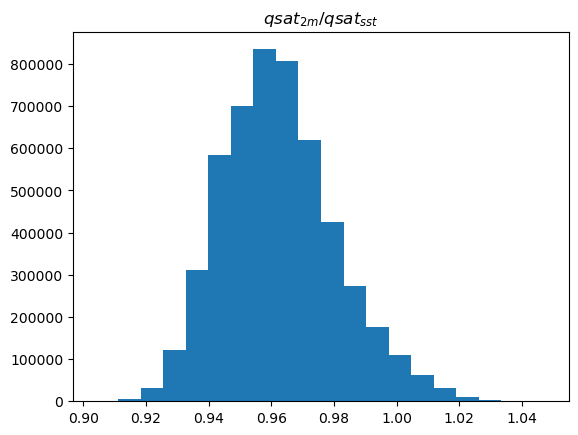

In [23]:
plt.hist(qsat_2m[~np.isnan(qsat_2m)]/qsat_sst[~np.isnan(qsat_sst)], bins=20)
plt.title(r'$qsat_{2m}/qsat_{sst}$')
plt.show()

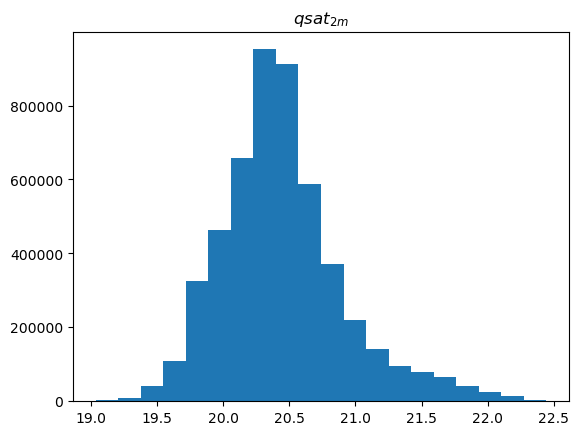

In [24]:
plt.hist(qsat_2m[~np.isnan(qsat_2m)], bins=20)
plt.title(r'$qsat_{2m}$')
plt.show()

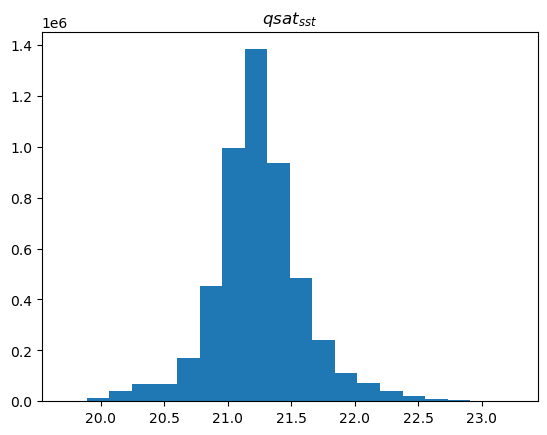

In [25]:
plt.hist(qsat_sst[~np.isnan(qsat_sst)], bins=20)
plt.title(r'$qsat_{sst}$')
plt.show()

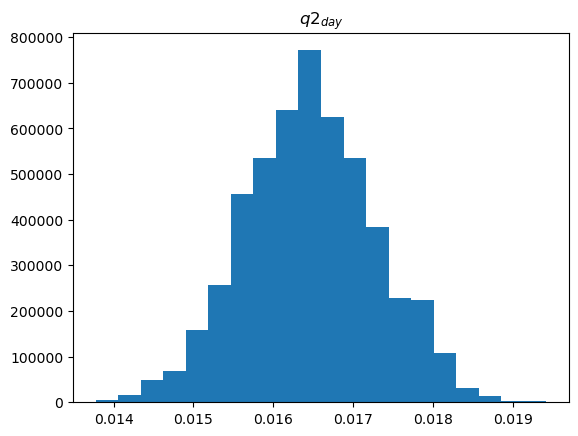

In [26]:
plt.hist(q2_day[~np.isnan(q2_day)], bins=20)
plt.title(r'$q2_{day}$')
plt.show()

In [22]:
d_delta_q = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/DdeltaQ_day_feb.npy')
d_delta_q = d_delta_q*sea_mask_modified_nan 

In [28]:
dq2 = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/dq2_day_feb.npy')
dq2 = dq2*sea_mask_modified_nan

/venus/tesi_ale/img_EU/T/daily/FEB/scatterFIT_T2-sst_dT2-dsst_fullDom.png


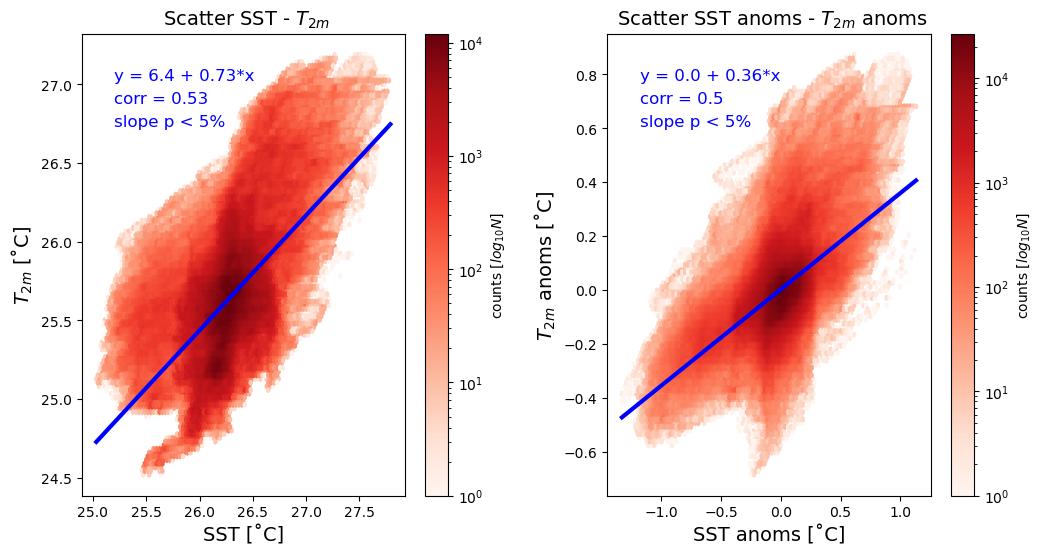

In [38]:
#####  LINKING T2 WITH SST


# variaiton of qsat and q2 with SST and dSST
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

anoms = False

x =  sst_day*mask-273.15
y =  T2*mask-273.15
fit_T2_sst, corcoe_T2_sst, p_value_T2_sst, p_value_cannelli_T2_sst, sigmas_coeffs_T2_sst = slopes_r_p_mix(x, y, nt, nskip)
   
density_hexbin_subplots(x, y, fit=fit_T2_sst, corcoe=corcoe_T2_sst, grdsz=100, fig=fig, ax=ax1,\
                        title=' Scatter SST - $T_{2m}$', xlabel='SST [˚C]', ylabel='$T_{2m}$ [˚C]', colormap='Reds', pos=[0.1,0.9])
    

    
if p_value_cannelli_T2_sst < 0.05:
    ax1.annotate('slope p < 5%', xy=(0.1, 0.8), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    ax1.annotate('slope p > 5%', xy=(0.1, 0.8), \
                         xycoords='axes fraction', fontsize=12, color='b')
    
    

    
    
    
xx = dsst_day.values*mask
yy = dT2*mask
fit_dT2_dsst, corcoe_dT2_dsst, p_value_dT2_dsst, p_value_cannelli_dT2_dsst, sigmas_coeffs_dT2_dsst = slopes_r_p_mix(xx, yy, nt, nskip)
# ls_therm_contr = fit_qsat_sst.slope

density_hexbin_subplots(xx, yy, fit=fit_dT2_dsst, corcoe=corcoe_dT2_dsst, grdsz=100, fig=fig, ax=ax2,\
                        title=' Scatter SST anoms - $T_{2m}$ anoms', xlabel='SST anoms [˚C]', ylabel='$T_{2m}$ anoms [˚C]', colormap='Reds', pos=[0.1,0.9])




if p_value_cannelli_dT2_dsst < 0.05:
    ax2.annotate('slope p < 5%', xy=(0.1, 0.8), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    ax2.annotate('slope p > 5%', xy=(0.1, 0.8), \
                         xycoords='axes fraction', fontsize=12, color='b')



plt.subplots_adjust(wspace=0.3, 
                    hspace=0.4)

path_img = '/venus/tesi_ale/img_EU/T/daily/FEB/' 
filename = path_img + 'scatterFIT_T2-sst_dT2-dsst_fullDom.png' # if dsst else path_img + 'scatterFIT_sst_DELTAQ_feb.png'
# plt.savefig(filename)
print(filename)
del filename

In [49]:
pdist_sst, pdist_q2_day, pstd_q2_day, pstderr_q2_day, pnpoints_q2_day, ppvalue_q2_day =   distrib_2d(sst_day, q2_day, perc_step, nbins, popmean, perc_fixbin='perc')
pdist_dsst, pdist_dq2, pstd_dq2, pstderr_dq2, pnpoints_dq2, ppvalue_dq2 =   distrib_2d(dsst_day.values, dq2, perc_step, nbins, popmean, perc_fixbin='perc')


/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/scatterFIT_dsst_dQsat_dQ2_fullDom.png


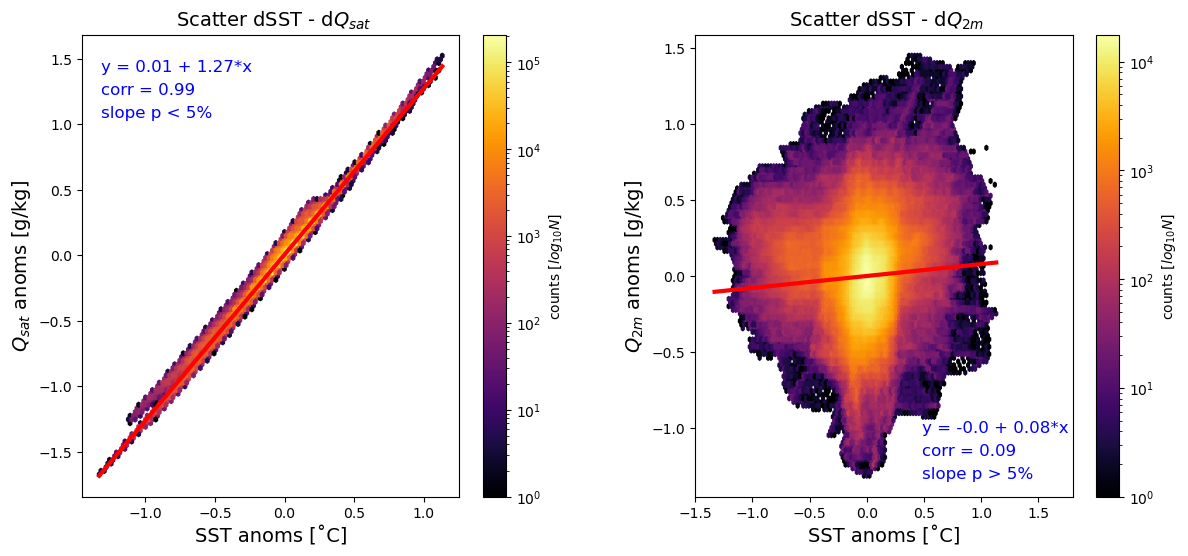

In [39]:
# slope p value > 0.05# variaiton of qsat and q2 with SST and dSST
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6))

anoms = True

x = dsst_day.values if anoms else (sst_day-273.15); x = x*mask
y = dqsat_sst if anoms else qsat_sst;               y = y*mask

fit_qsat_sst, corcoe_qsat, p_value_qsat, p_value_cannelli_qsat, sigmas_coeffs_qsat = slopes_r_p_mix(x, y, nt, nskip)
# ls_therm_contr = fit_qsat_sst.slope
   
density_hexbin_subplots(x, y, fit=fit_qsat_sst, corcoe=corcoe_qsat, grdsz=100, fig=fig, ax=ax1,\
                        title=' Scatter dSST - d$Q_{sat}$', xlabel='SST anoms [˚C]', ylabel='$Q_{sat}$ anoms [g/kg]', colormap='inferno', pos=[0.05,0.92])
    

if p_value_cannelli_qsat < 0.05:
    ax1.annotate('slope p < 5%', xy=(0.05, 0.82), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    ax1.annotate('slope p > 5%', xy=(0.05, 0.82), \
                         xycoords='axes fraction', fontsize=12, color='b')
    
    
xx = x
yy = dq2*1000. if anoms else q2_day*1000.;  yy = yy*mask
# xxx = pdist_dsst if anoms else pdist_sst-273.15 
# yyy = pdist_dq2*1000 if anoms else pdist_q2_day*1000


fit_q2_sst, corcoe_q2, p_value_q2, p_value_cannelli_q2, sigmas_coeffs_q2 = slopes_r_p_mix(xx, yy, nt, nskip)
# ls_therm_contr = fit_qsat_sst.slope

density_hexbin_subplots(xx, yy, fit=fit_q2_sst, corcoe=corcoe_q2, grdsz=100, fig=fig, ax=ax2,\
                        title=' Scatter dSST - d$Q_{2m}$', xlabel='SST anoms [˚C]', ylabel='$Q_{2m}$ anoms [g/kg]', colormap='inferno', pos=[0.6,0.14])
ax2.set_xlim([-1.5, 1.8])
# ax2.plot(xxx, yyy, '*b')

if p_value_cannelli_q2 < 0.05:
    ax2.annotate('slope p < 5%', xy=(0.6, 0.04), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    ax2.annotate('slope p > 5%', xy=(0.6, 0.04), \
                         xycoords='axes fraction', fontsize=12, color='b')


    

plt.subplots_adjust(wspace=0.3, 
                    hspace=0.4)


######  PREVIOUSLY SAVED IN QVAPOR  #######
path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
filename = path_img + 'scatterFIT_dsst_dQsat_dQ2_fullDom.png' if anoms else path_img + 'scatterFIT_sst_Qsat_Q2_fullDom.png'
print(filename)
# plt.savefig(filename)
del filename
######  PREVIOUSLY SAVED IN QVAPOR  #######

In [29]:
pdist_sst, pdist_deltaQ, pstd_deltaQ, pstderr_deltaQ, pnpoints_deltaQ, ppvalue_deltaQ        =   distrib_2d(sst_day, delta_q.magnitude, perc_step, nbins, popmean, perc_fixbin='perc')
pdist_dsst, pdist_DdeltaQ, pstd_DdeltaQ, pstderr_DdeltaQ, pnpoints_DdeltaQ, ppvalue_DdeltaQ  =   distrib_2d(dsst_day.values, d_delta_q, perc_step, nbins, popmean, perc_fixbin='perc')


/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/scatterFIT_dsst_dDELTAQ_fullDom.png


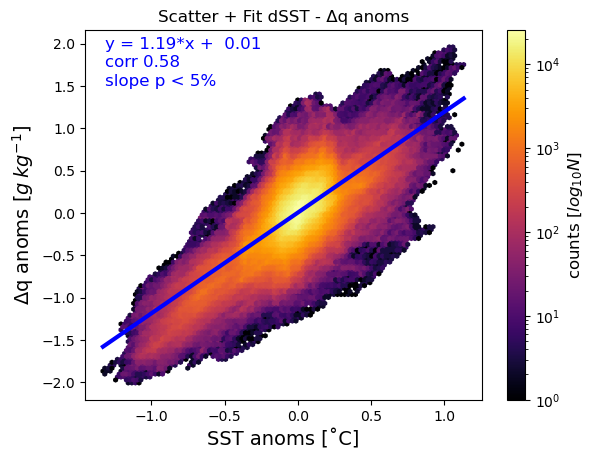

In [27]:
##### FITTING #####

# # corr length
# L = 80
# nskip = int(L/2)
# nt = int(2)
# nbin = 50
dsst = True
mask = sea_mask_modified_nan

if not dsst:
    x = (sst_day-273.15).copy()*mask    
    y = delta_q.copy()*mask
    
#     xx, yy = pdist_sst-273.15, pdist_deltaQ
    
    fit_dq_sst, corcoe_dq, p_value_dq, p_value_cannelli_dq, sigmas_coeffs_dq_full = slopes_r_p_mix(x, y, nt, nskip)
    ls_therm_contr = fit_dq_sst.slope
    
    title=' Scatter + Fit SST - Δq'
    xlabel='SST [˚C]'
    ylabel=r'Δq [$g\:kg^{-1}$]'
    fig = density_hexbin(x,y,plot_fit=True,fit=fit_dq_sst,corcoe=corcoe_dq,grdsz=100,\
                         title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno', pos=[0.5,0.15])
#     plt.plot(xx, yy, '*b')
    plt.ylim([1,7.5])
    
else:
    x = dsst_day.values.copy()*mask
    y = d_delta_q.copy()*mask
    
#     xx, yy = pdist_dsst, pdist_DdeltaQ
    
    fit_dq_dsst, corcoe_dq, p_value_dq, p_value_cannelli_dq, sigmas_coeffs_dq_ss  = slopes_r_p_mix(x, y, nt, nskip)
    ss_therm_contr = fit_dq_dsst.slope
    
    title='Scatter + Fit dSST - Δq anoms'
    xlabel='SST anoms [˚C]'
    ylabel=r'Δq anoms [$g\:kg^{-1}$]'
    fig = density_hexbin(x,y,plot_fit=True,fit=fit_dq_dsst,corcoe=corcoe_dq,grdsz=100,\
                         title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno',pos=[0.05,0.95])
#     plt.plot(xx, yy, '*b')
    

    
if p_value_cannelli_dq < 0.05:
    plt.annotate('slope p < 5%', xy=(0.05, 0.85), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    plt.annotate('slope p > 5%', xy=(0.05, 0.85), \
                         xycoords='axes fraction', fontsize=12, color='b')


    

######  PREVIOUSLY SAVED IN QVAPOR  #######    
path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
filename = path_img + 'scatterFIT_dsst_dDELTAQ_fullDom.png' if dsst else path_img + 'scatterFIT_sst_DELTAQ_fullDom.png'
# plt.savefig(filename)
print(filename)
del filename
######  PREVIOUSLY SAVED IN QVAPOR  #######

## relative humidity RH

In [6]:
##### study density of RH2
rh2_day = np.load('/venus/tesi_ale/data_EU/RH/daily/FEB/rh2_day.npy')*sea_mask_modified_nan
drh2_day = np.load('/venus/tesi_ale/data_EU/RH/daily/FEB/drh2_day.npy')*sea_mask_modified_nan

In [18]:
perc_step = 5; nbins = int(100/perc_step)

pdist_dsst, pdist_drh, pstd_drh, pstderr_drh, pnpoints_drh, ppvalue_drh =   distrib_2d(dsst_day.values, drh2_day, perc_step, nbins, popmean, perc_fixbin='perc')
pdist_sst, pdist_rh, pstd_rh, pstderr_rh, pnpoints_rh, ppvalue_rh =   distrib_2d(sst_day, rh2_day, perc_step, nbins, popmean, perc_fixbin='perc')

/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/scatterFIT_sst_RH_fullDom.png
slope sigma: 1.134


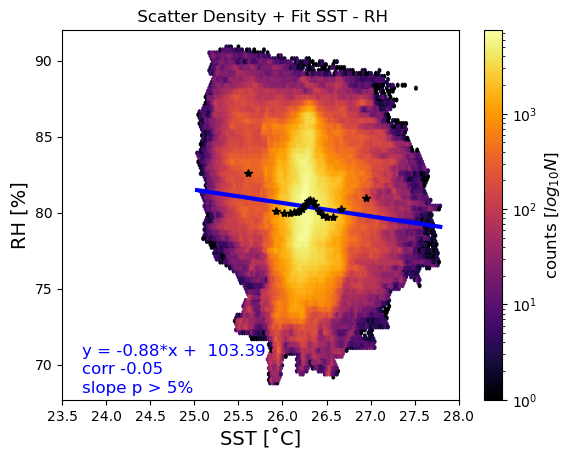

In [28]:
dsst = False

if not dsst:
    x =  (sst_day-273.15).copy()
    y =  rh2_day.copy()     
    
    xx, yy = pdist_sst-273.15, pdist_rh
    
    fit, corcoe, p_value, p_value_cannelli, sigmas = slopes_r_p_mix(x, y, nt, nskip)
    title=' Scatter Density + Fit SST - RH'
    xlabel='SST [˚C]'
    ylabel='RH [%]'
    
else:
    x = dsst_day.values.copy()
    y = drh2_day.copy()
    
    xx, yy = pdist_dsst, pdist_drh
    
    fit, corcoe, p_value, p_value_cannelli, sigmas = slopes_r_p_mix(x, y, nt, nskip)
    title='Scatter Density + Fit dSST - dRH'
    xlabel='SST anoms [˚C]'
    ylabel='RH anoms [%]'
    '''miny = -150 ; maxy = 100
    minx = -2 ; maxx = 1'''
    
pos=[0.05,0.12]
fig = density_hexbin(x,y,plot_fit=True,fit=fit,corcoe=corcoe,grdsz=100,\
                     title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno', pos=pos)

plt.plot(xx, yy, '*', color='k')

plt.xlim([23.5, 28])
    
if p_value_cannelli < 0.05:
    plt.annotate('slope p < 5%', xy=(pos[0], pos[1]-0.1), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    plt.annotate('slope p > 5%', xy=(pos[0], pos[1]-0.1), \
                         xycoords='axes fraction', fontsize=12, color='b')

    

path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
filename = path_img + 'scatterFIT_dsst_dRH_fullDom.png' if dsst else path_img + 'scatterFIT_sst_RH_fullDom.png'
# plt.savefig(filename)

print(filename)

print(f'slope sigma: {round(sigmas[0], 3)}')

del filename

In [ ]:
###### trying to estimate aerodynamic coefficient

In [28]:
U = np.load('/venus/tesi_ale/data_EU/WIND/daily/FEB/U/U_day_feb.npy')*mask
V = np.load('/venus/tesi_ale/data_EU/WIND/daily/FEB/V/V_day_feb.npy')*mask

ws = np.sqrt(U**2+V**2)

# I KNOW THIS IS WRONG, I SHOULD CORRECT IT FOR THE LOG PROFILE
ws_10 = ws[:,0,:,:] #(ws[:,0,:,:]+ws[:,1,:,:])*0.5 

del U, V, ws

In [29]:
## trying to estimate air density, see if ths changes the estimate of C
T_virt = (T2*units.kelvin)*(1+0.61*q2_day*units('kg/kg'))
Rd = 287.058
rho_air = pres_sfc*100/(Rd*T_virt.magnitude)   # pressure is in hPa

In [30]:
L_v = 2.5008991412E+03  # units = J/kg  ; function in meteo.py is a correction of order 10^4/10^6 = 10^-2

ingredients = L_v*ws_10*(delta_q) # units = J/kg * m/s
ingredients_rho = rho_air*L_v*ws_10*(delta_q) #  # units = W/m2

/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/scatterFIT_C_fullDom.png


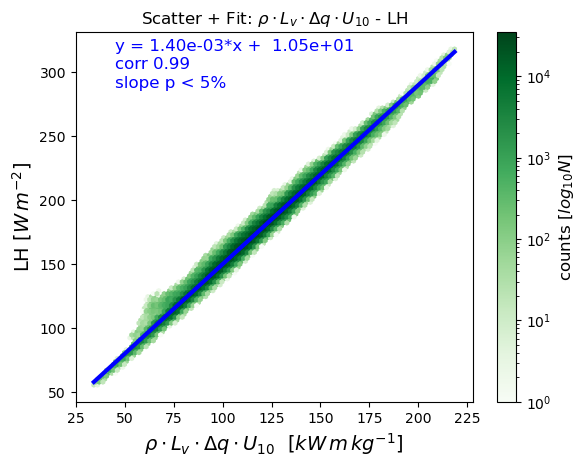

In [31]:
# FIT FOR    C

x = ingredients_rho.values.copy()*mask 
y = LH.copy()*mask

fit_rho, corcoe_rho, p_value_rho, p_value_cannelli_rho, sigmas_coeffs_rho = slopes_r_p_mix(x, y, nt, nskip)
title=r'Scatter + Fit: $\rho \cdot L_v \cdot \Delta q \cdot U_{10}$ - LH'
xlabel=r'$\rho \cdot L_v \cdot \Delta q \cdot U_{10}$  [$kW \, m \, kg^{-1}$]'
ylabel='LH [$W\,m^{-2}$]'

plt.xticks([25*(10**3), 50*(10**3), 75*(10**3), 100*(10**3), 125*(10**3), 150*(10**3), 175*(10**3),200*(10**3), 225*(10**3)],\
           ['25', '50', '75', '100', '125', '150','175', '200', '225'])  
 

fig = density_hexbin(x,y,plot_fit=True,fit=fit_rho,corcoe=corcoe_rho,grdsz=100,\
                     title=title,xlabel=xlabel,ylabel=ylabel, colormap='Greens', pos=[0.1,0.95])


if p_value_cannelli_rho < 0.05:
    plt.annotate('slope p < 5%', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    plt.annotate('slope p > 5%', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=12, color='b')
    
path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
filename = path_img + 'scatterFIT_C_fullDom.png'
# plt.savefig(filename)
print(filename)
del filename

/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/scatterFIT_rho-C_fullDom.png


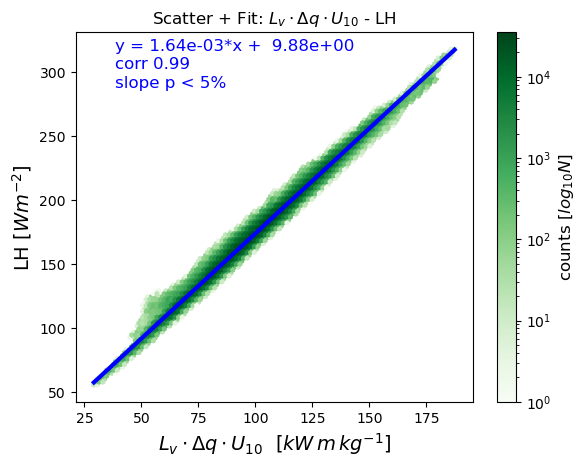

In [33]:
# FIT FOR    rho C

x = (ingredients.copy()*mask)
y = LH.copy()*mask

fit_lh, corcoe_lh, p_value_lh, p_value_cannelli_lh, sigmas_coeffs_lh = slopes_r_p_mix(x, y, nt, nskip)
title=r'Scatter + Fit: $L_v \cdot \Delta q \cdot U_{10}$ - LH'
xlabel=r'$L_v \cdot \Delta q \cdot U_{10}$  [$kW \, m \, kg^{-1}$]'
ylabel='LH [$Wm^{-2}$]'

plt.xticks([25*(10**3), 50*(10**3), 75*(10**3), 100*(10**3), 125*(10**3), 150*(10**3), 175*(10**3)],\
           ['25', '50', '75', '100', '125', '150','175'])   # 200*(10**3), 225*(10**3)  # , '200', '225'
 

fig = density_hexbin(x,y,plot_fit=True, fit=fit_lh,corcoe=corcoe_lh,grdsz=100,\
                     title=title,xlabel=xlabel,ylabel=ylabel, colormap='Greens', pos=[0.1,0.95])


if p_value_cannelli_lh < 0.05:
    plt.annotate('slope p < 5%', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    plt.annotate('slope p > 5%', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=12, color='b')

    
path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
filename = path_img + 'scatterFIT_rho-C_fullDom.png'
# plt.savefig(filename)
print(filename)
del filename

In [34]:
rho_C = round(fit_lh.slope, 4);    sigma_rhoC = round(sigmas_coeffs_lh[0], 5)
C = round(fit_rho.slope, 4);       sigma_C = round(sigmas_coeffs_rho[0], 5)

#### RESULT IS VERY MUCH IN LINE WITH VALUE USED BY PABLO!
#### THERE IS ONLY THAT INTERCEPT RUINING THE PARTY

msg = f'C = {C} ± {sigma_C}\nrho_C = {rho_C} ± {sigma_rhoC} \nrelative errors respectively {round(sigma_C/C, 4)} and {sigma_rhoC/rho_C}'
print(msg)

C = 0.0014 ± 1e-05
rho_C = 0.0016 ± 2e-05 
relative errors respectively 0.0071 and 0.0125


In [35]:
# find most frequent thermodyn contr
ws_10_mode = np.mean(ws_10[~np.isnan(ws_10)], axis=None)
rho_mode = np.mean(rho_air.values[~np.isnan(rho_air.values)], axis=None)

In [36]:
print(f'large scale rho_C = {round(rho_C*L_v*ls_therm_contr*(ws_10_mode),3)} W/m2')
print(f'large scale C     = {round((rho_mode)*C*L_v*ls_therm_contr*(ws_10_mode),3)} W/m2')
print('\n')
print(f'small scale rho_C = {round(rho_C*L_v*ss_therm_contr*(ws_10_mode),3)} W/m2')
print(f'small scale C     = {round((rho_mode)*C*L_v*ss_therm_contr*(ws_10_mode),3)} W/m2')

large scale rho_C = 24.718 W/m2
large scale C     = 25.317 W/m2


small scale rho_C = 39.868 W/m2
small scale C     = 40.835 W/m2


So far, I have been comparing the FULL FIELDS with ANOMALIES

I am now to study the actual differences between SMOOTH FIELDS and ANOMALIES --> SPLIT THE SPECTRUM!!

In [15]:
# #### SST SMOOTH
# with open('/venus/tesi_ale/data_EU/SST/daily/FEB/dSST_day_feb.npy', 'rb') as f:
#     dsst_day = np.load(f)
#     f.close()

sst_smooth = sst_day - dsst_day.values;   sst_smooth -= 273.15

In [38]:
#### T2 SMOOTH
T2_smooth = T2 - dT2;              T2_smooth -= 273.15

In [105]:
### LHF smooth 
LH_smooth = LH-dLH

In [51]:
#### RH2 SMOOTH
rh2_day = np.load('/venus/tesi_ale/data_EU/RH/daily/FEB/rh2_day.npy')*sea_mask_modified_nan
drh2_day = np.load('/venus/tesi_ale/data_EU/RH/daily/FEB/drh2_day.npy')*sea_mask_modified_nan

rh2_smooth = rh2_day - drh2_day

In [52]:
#### QSAT_SST SMOOTH
# qsat_sst = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/qsat_sst_day.npy')
# dqsat_sst = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/dqsat_sst_day.npy')

qsat_sst_smooth = qsat_sst - dqsat_sst

In [29]:
#### Q2 SMOOTH
# dq2 = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/dq2_day_feb.npy')

q2_smooth = q2_day - dq2

In [41]:
#### DELTA_Q SMOOTH
# delta_q = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/deltaQ_day_feb.npy')
# d_delta_q = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/DdeltaQ_day_feb.npy')

deltaq_smooth = delta_q - d_delta_q

In [67]:
np.nanmax(delta_q)

6.961589813232422 <Unit('gram / kilogram')>

/venus/tesi_ale/img_EU/RH/daily/FEB/scatterFIT_T2-smooth_sst-smooth_feb.png


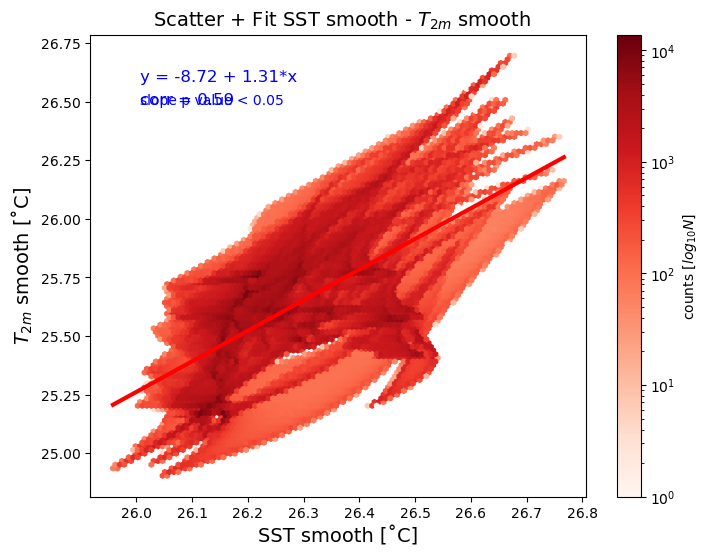

In [57]:
####### CHECK THAT FULL T2 vs SST
####### FOLLOWS T2 vs SST smooth

fig, ax = plt.subplots(1,1, figsize=(8,6))

x =  sst_smooth
y =  T2_smooth-273.15
fit_T2_sst_sm, corcoe_T2_sst_sm, p_value_T2_sst_sm, p_value_cann_T2_sst_sm, sigmas_T2_sst_sm = slopes_r_p_mix(x, y, nt, nskip)

hfx_sensitivity_smooth = fit_T2_sst_sm.slope

pos = [0.1, 0.9]
density_hexbin_subplots(x, y, fit=fit_T2_sst_sm, corcoe=corcoe_T2_sst_sm, grdsz=100, fig=fig, ax=ax,\
                        title=r' Scatter + Fit SST smooth - $T_{2m}$ smooth', xlabel='SST smooth [˚C]', ylabel=r'$T_{2m}$ smooth [˚C]', colormap='Reds', pos=pos)
    

    
if p_value_cann_T2_sst_sm < 0.05:
    ax.annotate('slope p value < 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    ax.annotate('slope p value > 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=10, color='b')

    
    
path_img = '/venus/tesi_ale/img_EU/RH/daily/FEB/' 
filename = path_img + 'scatterFIT_T2-smooth_sst-smooth_feb.png'
#plt.savefig(filename)
print(filename)
del filename    


0.5141983737969724

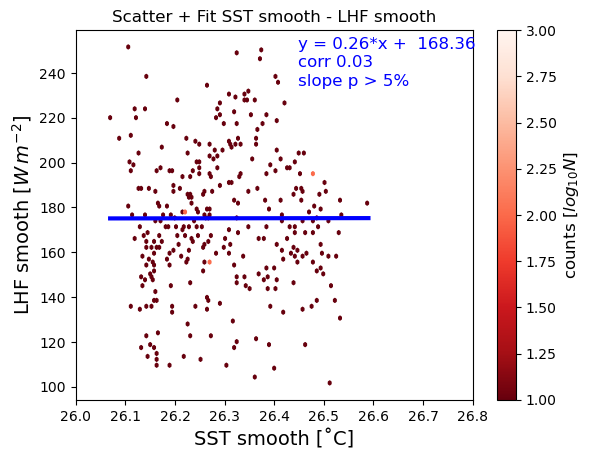

In [25]:
### DELTA_Q vs SST smooth


x = sst_smooth.copy()
y = LH_smooth.copy()

posx, posy_fit = 0.56, 0.95

fit_LH_sst_sm, corcoe_LH_sst_sm, p_value_LH_sst_sm, pval_cann_LH_sst_sm, sigmas_LH_sst_sm  = slopes_r_p_mix(x, y, nt, nskip)
#smooth_therm_contr = fit_LH_sst_sm.slope
    
title=r'Scatter + Fit SST smooth - LHF smooth'
xlabel='SST smooth [˚C]'
ylabel=r'LHF smooth [$W\,m^{-2}$]'

x = x[:,::110,::110]
y = y[:,::110,::110]

fig = density_hexbin(x, y, plot_fit=True, fit=fit_LH_sst_sm, corcoe=corcoe_LH_sst_sm, grdsz=100,\
                     title=title, xlabel=xlabel, ylabel=ylabel, colormap='Reds_r',pos=[posx,posy_fit])
    
plt.xlim([26, 26.8])
    
if pval_cann_LH_sst_sm < 0.05:
    plt.annotate('slope p < 5%', xy=(posx, posy_fit-0.1), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    plt.annotate('slope p > 5%', xy=(posx, posy_fit-0.1), \
                         xycoords='axes fraction', fontsize=12, color='b')


       
path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
# filename = path_img + 'scatterFIT_LH-smooth_sst-smooth_feb.png'
#plt.savefig(filename)
# print(filename)
# del filename

/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/scatterFIT_qsat-smooth_sst-smooth_feb.png


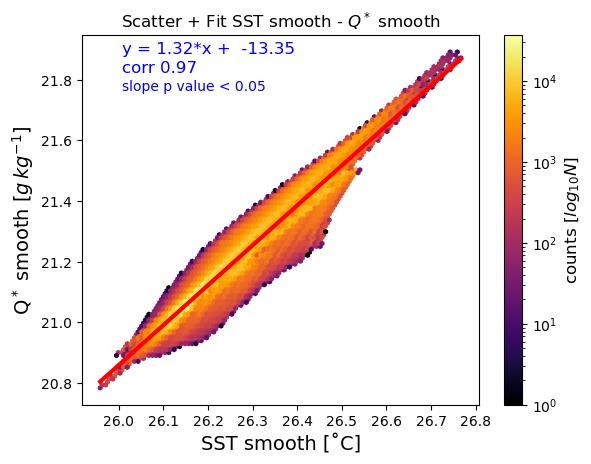

In [70]:
### DELTA_Q vs SST smooth

x = sst_smooth.copy()
y = qsat_sst_smooth.copy()

posx, posy_fit = 0.1, 0.95

fit_qsat_sst_sm, corcoe_qsat_sst_sm, p_value_qsat_sst_sm, pval_cann_qsat_sst_sm, sigmas_qsat_sst_sm  = slopes_r_p_mix(x, y, nt, nskip)
#smooth_therm_contr = fit_qsat_sst_sm.slope
    
title=r'Scatter + Fit SST smooth - $Q^*$ smooth'
xlabel='SST smooth [˚C]'
ylabel=r'$\rm Q^*$ smooth [$g\,kg^{-1}$]'
fig = density_hexbin(x, y, plot_fit=True, fit=fit_qsat_sst_sm, corcoe=corcoe_qsat_sst_sm, grdsz=100,\
                     title=title, xlabel=xlabel, ylabel=ylabel, colormap='inferno',pos=[posx,posy_fit])
    

    
if pval_cann_qsat_sst_sm < 0.05:
    plt.annotate('slope p value < 0.05', xy=(posx, posy_fit-0.1), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(posx, posy_fit-0.1), \
                         xycoords='axes fraction', fontsize=10, color='b')


       
path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
filename = path_img + 'scatterFIT_qsat-smooth_sst-smooth_feb.png'
#plt.savefig(filename)
print(filename)
del filename

/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/scatterFIT_q2-smooth_sst-smooth_fullDom.png


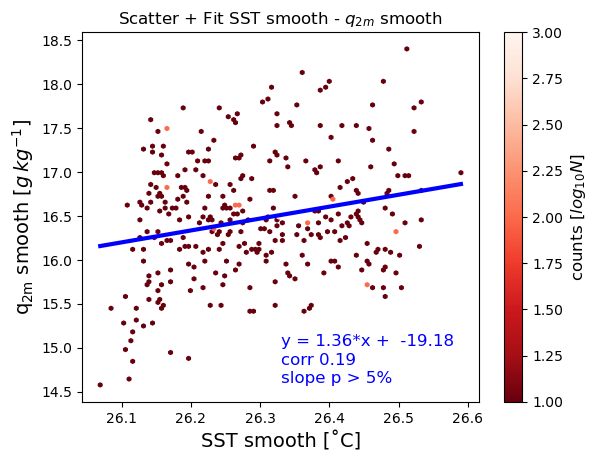

In [32]:
### DELTA_Q vs SST smooth

x = sst_smooth.copy()
y = q2_smooth.copy()*1000

nskip_sm = 110

posx, posy_fit = 0.5, 0.15

fit_q2_sst_sm, corcoe_q2_sst_sm, p_value_q2_sst_sm, pval_cann_q2_sst_sm, sigmas_q2_sst_sm  = slopes_r_p_mix(x, y, nt, nskip_sm)
#smooth_therm_contr = fit_q2_sst_sm.slope
    
title=r'Scatter + Fit SST smooth - $q_{2m}$ smooth'
xlabel='SST smooth [˚C]'
ylabel=r'$\rm q_{2m}$ smooth [$g\,kg^{-1}$]'


x = x[:,::110,::110]
y = y[:,::110,::110]


fig = density_hexbin(x, y,plot_fit=True, fit=fit_q2_sst_sm, corcoe=corcoe_q2_sst_sm, grdsz=100,\
                     title=title, xlabel=xlabel, ylabel=ylabel, colormap='Reds_r',pos=[posx,posy_fit])
    

    
if pval_cann_q2_sst_sm < 0.05:
    plt.annotate('slope p < 5%', xy=(posx, posy_fit-0.1), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    plt.annotate('slope p > 5%', xy=(posx, posy_fit-0.1), \
                         xycoords='axes fraction', fontsize=12, color='b')


       
path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
filename = path_img + 'scatterFIT_q2-smooth_sst-smooth_fullDom.png'
# plt.savefig(filename)
print(filename)
del filename

In [59]:
sigmas_q2_sst_sm

(0.4820074682104648, 12.674203232724052)

/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/pointRegr_q2-smooth_sst-smooth_feb.png


"hatch_mask = np.zeros_like(slope_q2_sst)\nhatch_mask[p_val_q2_sst > 0.05] = 1\ncont1 = ax1.contourf(lon_M, lat_M, hatch_mask, levels=[0.9, 1.1], hatches=['...', None],  colors='none', alpha=0.1)"

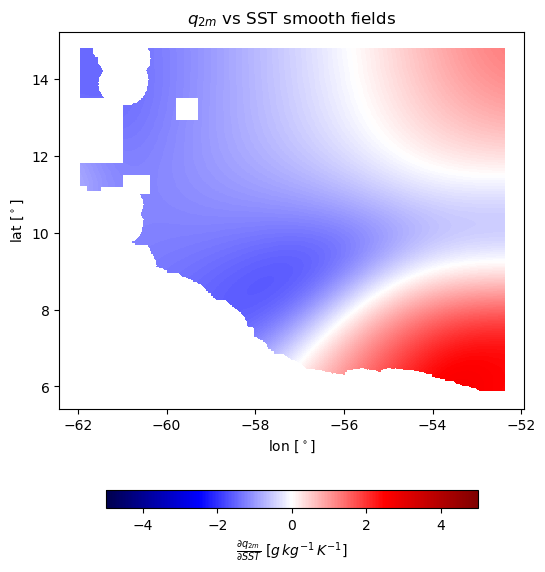

In [23]:
##### POINTWISE REGRESSIONS
import matplotlib as mpl

fig, ax1 = plt.subplots(1,1, figsize=(6,7))


x = sst_smooth.copy()         
y = q2_smooth*1000.                   

n_q2_sst, slope_q2_sst, intercept_q2_sst, cor_q2_sst, p_val_q2_sst, r_square_q2_sst, rmse_q2_sst =\
regression.MY_point_regr(x,y) 

p1 = ax1.pcolormesh(lon_M, lat_M, slope_q2_sst, vmin=-5, vmax=5, cmap='seismic')

cbar1 = plt.colorbar(p1,ax=ax1, location='bottom', shrink=0.8)#, extend='both')  
cbar1.set_label(r'$\frac{\partial q_{2m}}{\partial SST}$ [$g\,kg^{-1}\,K^{-1}$]')
ax1.set_title(r'$q_{2m}$ vs SST smooth fields'); ax1.set_xlabel('lon [$^\circ$]'); ax1.set_ylabel('lat [$^\circ$]')

path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
filename = path_img + 'pointRegr_q2-smooth_sst-smooth_feb.png'
# plt.savefig(filename)
print(filename)
del filename


# Hatching for p-values less than 0.05
'''lat_hatch = lat_M[p_val_LH_sst > 0.05]
lon_hatch = lon_M[p_val_LH_sst > 0.05]
ax1.scatter(lon_hatch, lat_hatch, s=0.01, color='k')'''
'''hatch_mask = np.zeros_like(slope_q2_sst)
hatch_mask[p_val_q2_sst > 0.05] = 1
cont1 = ax1.contourf(lon_M, lat_M, hatch_mask, levels=[0.9, 1.1], hatches=['...', None],  colors='none', alpha=0.1)'''

/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/scatterFIT_rh-smooth_sst-smooth_fullDom.png


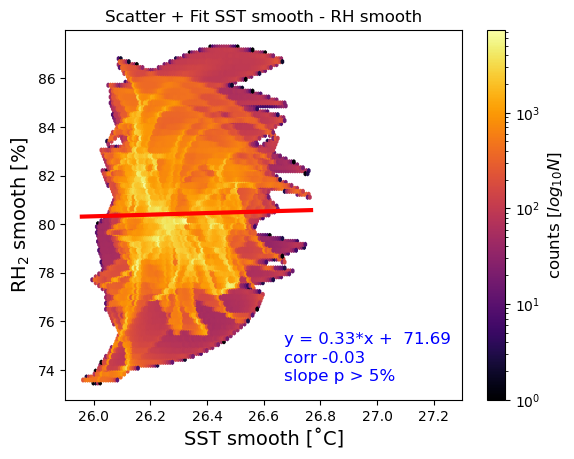

In [72]:
##### RH vs SST smooth
### you can find small scale computations in QVAPOR_day.ipynb

x = sst_smooth.copy()
y = rh2_smooth.copy()
fit_rh_sst_sm, corcoe_rh_sst_sm, p_value_rh_sst_sm, pval_cann_rh_sst_sm, sigmas_rh_sst_sm  = slopes_r_p_mix(x, y, nt, nskip)
#smooth_therm_contr = fit_rh_sst_sm.slope
    
title='Scatter + Fit SST smooth - RH smooth'
xlabel='SST smooth [˚C]'
ylabel=r'$\rm RH_{2}$ smooth [%]'
pos=[0.55,0.15]
fig = density_hexbin(x, y, plot_fit=True, fit=fit_rh_sst_sm, corcoe=corcoe_rh_sst_sm, grdsz=100,\
                     title=title, xlabel=xlabel, ylabel=ylabel, colormap='inferno',pos=pos)

plt.xlim([25.9, 27.3])

    
if pval_cann_rh_sst_sm < 0.05:
    plt.annotate('slope p < 5%', xy=(pos[0], pos[1]-0.1), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    plt.annotate('slope p > 5%', xy=(pos[0], pos[1]-0.1), \
                         xycoords='axes fraction', fontsize=12, color='b')


       
path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
filename = path_img + 'scatterFIT_rh-smooth_sst-smooth_fullDom.png'
# plt.savefig(filename)
print(filename)
del filename


/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/scatterFIT_deltaq-smooth_sst-full_feb.png


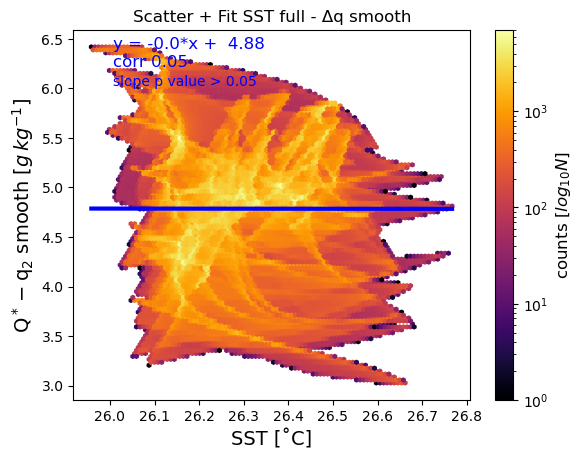

In [42]:
### DELTA_Q vs SST smooth

x = sst_smooth.copy()
y = deltaq_smooth.copy()
nskip_sm = 200
posx, posy_fit = 0.1, 0.95

fit_deltaq_sst_sm, corcoe_deltaq_sst_sm, p_value_deltaq_sst_sm, pval_cann_deltaq_sst_sm, sigmas_deltaq_sst_sm  = slopes_r_p_mix(x, y, nt, nskip=nskip_sm)
smooth_therm_contr = fit_deltaq_sst_sm.slope
    
title='Scatter + Fit SST full - Δq smooth'
xlabel='SST [˚C]'
ylabel=r'$\rm Q^* - q_{2}$ smooth [$g\,kg^{-1}$]'
fig = density_hexbin(x, y, plot_fit = True, fit=fit_deltaq_sst_sm, corcoe=corcoe_deltaq_sst_sm, grdsz=100,\
                     title=title, xlabel=xlabel, ylabel=ylabel, colormap='inferno',pos=[posx,posy_fit])
    

    
if pval_cann_deltaq_sst_sm < 0.05:
    plt.annotate('slope p value < 0.05', xy=(posx, posy_fit-0.1), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(posx, posy_fit-0.1), \
                         xycoords='axes fraction', fontsize=10, color='b')


       
path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
filename = path_img + 'scatterFIT_deltaq-smooth_sst-full_feb.png'
#plt.savefig(filename)
print(filename)
del filename

In [44]:
sigmas_deltaq_sst_sm

(92.97926142299823, 2444.8543506572873)

In [45]:
data1 = rho_C*L_v*ws_10*ls_therm_contr*mask; data1 = data1[~np.isnan(data1)]
data2 = rho_C*L_v*ws_10*ss_therm_contr*mask; data2 = data2[~np.isnan(data2)]
data3 = C*L_v*ws_10*ls_therm_contr*mask;     data3 = data3[~np.isnan(data3)]
data4 = C*L_v*ws_10*ss_therm_contr*mask;     data4 = data4[~np.isnan(data4)]

data5 = rho_C*L_v*ws_10*smooth_therm_contr;   data5 = data5[~np.isnan(data5)]
data6 = C*L_v*ws_10*smooth_therm_contr;       data6 = data6[~np.isnan(data6)]

In [46]:
sigmass = [sigmas_coeffs_dq_full[0], sigmas_coeffs_dq_full[0], sigmas_coeffs_dq_ss[0], sigmas_coeffs_dq_ss[0], sigmas_deltaq_sst_sm[0], sigmas_deltaq_sst_sm[0]]
slopes = [ls_therm_contr, ls_therm_contr, ss_therm_contr, ss_therm_contr, smooth_therm_contr, smooth_therm_contr]


In [47]:
sigmass

[0.2788927563310303,
 0.2788927563310303,
 0.11956846533606631,
 0.11956846533606631,
 92.97926142299823,
 92.97926142299823]

/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/violins_full-SS-LS_rho-C_fullDom.png


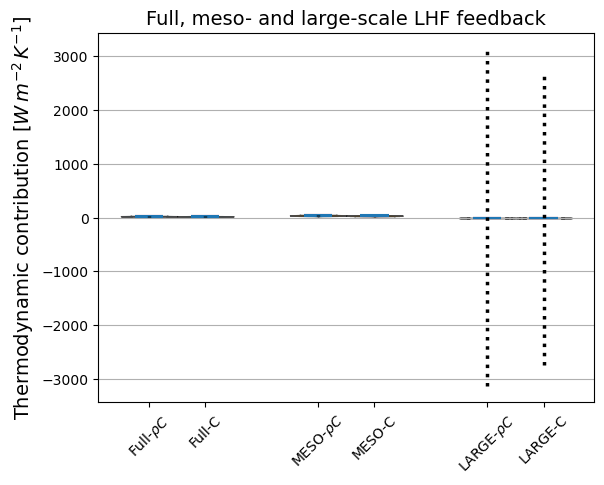

In [48]:

fig, axs = plt.subplots(1,1)
quants = [[0.1, 0.9] , [0.1, 0.9], [0.1, 0.9], [0.1, 0.9], [0.1, 0.9], [0.1, 0.9]]
pos = [ 1, 1.5, 2.5, 3., 4, 4.5]
colorz = ['skyblue', 'skyblue', 'orange', 'orange' , 'green', 'green']


plt.title('Full, meso- and large-scale LHF feedback', fontsize=14)


violin_parts1 = axs.violinplot([data1, data3, data2, data4, data5, data6],\
                               positions=pos, showmeans=False,\
                               showmedians=True, showextrema=False, quantiles=quants)
violin_parts1['cmedians'].set_color('red')



# set color of violins inside
for pc, color in zip(violin_parts1['bodies'], colorz):
    pc.set_facecolor(color)
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

    
for i, dataset in enumerate([data1, data3, data2, data4, data5, data6]):
    if int(i)%2 == 0:
        k = rho_C
    else:
        k = C
    
    up = k*L_v*ws_10*(slopes[i]+sigmass[i])*mask;  up = up[~np.isnan(up)]
    dn = k*L_v*ws_10*(slopes[i]-sigmass[i])*mask;  dn = dn[~np.isnan(dn)]

    med_up, med_dn = np.nanmedian(up), np.nanmedian(dn)
    axs.plot([pos[i], pos[i]], [med_dn, med_up], linestyle='dotted', color='k', lw=2.5)
    

# set labels I need
axs.yaxis.grid(True)
axs.set_ylabel(r'Thermodynamic contribution [$W\,m^{-2}\,K^{-1}$]', fontsize=14)

axs.set_xticks(pos)
axs.set_xticklabels([r'Full-$\rho C$','Full-C', r'MESO-$\rho C$', 'MESO-C', r'LARGE-$\rho C$', 'LARGE-C'], rotation=45)  # , 
axs.set_xlabel('')



# save img
path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
filename = path_img + 'violins_full-SS-LS_rho-C_fullDom.png'
# plt.savefig(filename)
print(filename)
del filename